In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install konlpy

In [ ]:
from keras import models
from keras import layers
from keras import optimizers, losses, metrics
from keras import preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

from konlpy.tag import Okt
from keras.callbacks import ModelCheckpoint

<br>
<br>
# 데이터 로드

Seq2Seq에서의 임베딩이 이전 예제와 다른 점은 아래와 같이 태그를 사용한다는 것입니다. 임베딩의 0~3번째에 각각 PADDING, START, END, OOV 태그를 넣습니다. 사실 그냥 똑같은 단어라고 보시면 됩니다. 다만 이 단어들이 Seq2Seq의 동작을 제어합니다. 

예를 들어, 디코더 입력에 START가 들어가면 디코딩의 시작을 의미합니다. 반대로 디코더 출력에 END가 나오면 디코딩을 종료합니다.
<br>
<br>
<br>

In [ ]:
# 태그 단어
PAD = "<PADDING>"   # 패딩
STA = "<START>"     # 시작
END = "<END>"       # 끝
OOV = "<OOV>"       # 없는 단어(Out of Vocabulary)

# 태그 인덱스
PAD_INDEX = 0
STA_INDEX = 1
END_INDEX = 2
OOV_INDEX = 3

# 데이터 타입
ENCODER_INPUT  = 0
DECODER_INPUT  = 1
DECODER_TARGET = 2

# 한 문장에서 단어 시퀀스의 최대 개수
max_sequences = 30

# 임베딩 벡터 차원
embedding_dim = 100

# LSTM 히든레이어 차원
lstm_hidden_dim = 128

# 정규 표현식 필터
RE_FILTER = re.compile("[.,!?\"':;~()]")

# 챗봇 데이터 로드
chatbot_data = pd.read_csv('/content/drive/My Drive/자연어처리/*.csv', encoding='utf-8')
question, answer = list(chatbot_data['Q']), list(chatbot_data['A'])

챗봇의 훈련을 위해서 송영숙님이 공개한 한글 데이터셋을 로드합니다. 질문과 대답, 감정 등 총 3개의 항목으로 구성되어 있습니다. 감정 분류는 Seq2Seq에 필요가 없기 때문에 사용하지 않습니다.

https://github.com/songys/Chatbot_data
<br>
<br>
<br>

In [ ]:
# 데이터 개수
len(question)

1042

In [ ]:
# # 데이터의 일부만 학습에 사용
# question = question[:5]
# answer = answer[:5]

# # 챗봇 데이터 출력
# for i in range(10):
#     print('Q : ' + question[i])
#     print('A : ' + answer[i])
#     print()

<br>
<br>
# 단어 사전 생성

In [ ]:
# 형태소분석 함수
def pos_tag(sentences):
    
    # KoNLPy 형태소분석기 설정
    tagger = Okt()
    
    # 문장 품사 변수 초기화
    sentences_pos = []
    
    # 모든 문장 반복
    for sentence in sentences:
        # 특수기호 제거
        sentence = re.sub(RE_FILTER, "", sentence)
        
        # 배열인 형태소분석의 출력을 띄어쓰기로 구분하여 붙임
        sentence = " ".join(tagger.morphs(sentence))
        sentences_pos.append(sentence)
        
    return sentences_pos

문장을 먼저 최소 단위인 토큰으로 나누어야 합니다. 한글 문장이라면 보통 KoNLPy(코엔엘파이)를 통해 형태소분석을 적용합니다. Hannanum, Kkma, Komoran, Mecab, Okt(Twitter) 등 여러가지 라이브러리를 동일한 인터페이스로 실행이 가능합니다.

KoNLPy는 자바로 구현이 되어 있습니다. 맥OS와 달리 윈도우 아나콘다는 아래와 같은 작업을 거쳐야 합니다.

< 1. 자바 설치 ><br>
커맨드창에서 'java -version' 명령어를 실행하여 버전이 1.7 이상이어야 합니다.

< 2. JPype1 설치 ><br>
파이썬에서 자바를 호출할 수 있는 라이브러리입니다.

< 3. KoNLPy 설치 ><br>
위의 두 가지가 미리 완료되어 있어야만 가능합니다.

아래 링크에서 좀 더 자세한 방법을 확인하시기 바랍니다.<br>
-> https://ericnjennifer.github.io/python_visualization/2018/01/21/PythonVisualization_Chapt1.html
<br>
<br>
<br>

In [ ]:
# 형태소분석 수행
question = pos_tag(question)
answer = pos_tag(answer)

# 형태소분석으로 변환된 챗봇 데이터 출력
# for i in range(10):
#     print('Q : ' + question[i])
#     print('A : ' + answer[i])
#     print()

In [ ]:
# 질문과 대답 문장들을 하나로 합침
sentences = []
sentences.extend(question)
sentences.extend(answer)

words = []

# 단어들의 배열 생성
for sentence in sentences:
    for word in sentence.split():
        words.append(word)

# 길이가 0인 단어는 삭제
words = [word for word in words if len(word) > 0]

# 중복된 단어 삭제
words = list(set(words))

# 제일 앞에 태그 단어 삽입
words[:0] = [PAD, STA, END, OOV]

질문과 대답 문장들을 합쳐서 전체 단어 사전을 만듭니다. 자연어처리에서는 항상 이렇게 단어를 인덱스에 따라 정리를 해야 합니다. 그래야지 문장을 인덱스 배열로 바꿔서 임베딩 레이어에 넣을 수 있습니다. 또한 모델의 출력에서 나온 인덱스를 다시 단어로 변환하는데도 필요합니다.
<br>
<br>
<br>

In [ ]:
# 단어 개수
len(words)

2345

In [ ]:
# 단어 출력
words[:20]

['<PADDING>',
 '<START>',
 '<END>',
 '<OOV>',
 '부러워',
 '워',
 '미치겠어',
 '지낸',
 '과일',
 '표현',
 '잘생겼어요',
 '않아',
 '포커페이스',
 '죄',
 '합격',
 '거짓말',
 '했다고',
 '좋아해요',
 '괜히',
 '책임질']

In [ ]:
# 단어와 인덱스의 딕셔너리 생성
word_to_index = {word: index for index, word in enumerate(words)}
index_to_word = {index: word for index, word in enumerate(words)}

In [ ]:
# 단어 -> 인덱스
# 문장을 인덱스로 변환하여 모델 입력으로 사용
dict(list(word_to_index.items())[:20])

{'<END>': 2,
 '<OOV>': 3,
 '<PADDING>': 0,
 '<START>': 1,
 '거짓말': 15,
 '과일': 8,
 '괜히': 18,
 '미치겠어': 6,
 '부러워': 4,
 '않아': 11,
 '워': 5,
 '잘생겼어요': 10,
 '좋아해요': 17,
 '죄': 13,
 '지낸': 7,
 '책임질': 19,
 '포커페이스': 12,
 '표현': 9,
 '합격': 14,
 '했다고': 16}

In [ ]:
# 인덱스 -> 단어
# 모델의 예측 결과인 인덱스를 문장으로 변환시 사용
dict(list(index_to_word.items())[:20])

{0: '<PADDING>',
 1: '<START>',
 2: '<END>',
 3: '<OOV>',
 4: '부러워',
 5: '워',
 6: '미치겠어',
 7: '지낸',
 8: '과일',
 9: '표현',
 10: '잘생겼어요',
 11: '않아',
 12: '포커페이스',
 13: '죄',
 14: '합격',
 15: '거짓말',
 16: '했다고',
 17: '좋아해요',
 18: '괜히',
 19: '책임질'}

<br>
<br>
# 전처리

In [ ]:
# 문장을 인덱스로 변환
def convert_text_to_index(sentences, vocabulary, type): 
    
    sentences_index = []
    
    # 모든 문장에 대해서 반복
    for sentence in sentences:
        sentence_index = []
        
        # 디코더 입력일 경우 맨 앞에 START 태그 추가
        if type == DECODER_INPUT:
            sentence_index.extend([vocabulary[STA]])
        
        # 문장의 단어들을 띄어쓰기로 분리
        for word in sentence.split():
            if vocabulary.get(word) is not None:
                # 사전에 있는 단어면 해당 인덱스를 추가
                sentence_index.extend([vocabulary[word]])
            else:
                # 사전에 없는 단어면 OOV 인덱스를 추가
                sentence_index.extend([vocabulary[OOV]])

        # 최대 길이 검사
        if type == DECODER_TARGET:
            # 디코더 목표일 경우 맨 뒤에 END 태그 추가
            if len(sentence_index) >= max_sequences:
                sentence_index = sentence_index[:max_sequences-1] + [vocabulary[END]]
            else:
                sentence_index += [vocabulary[END]]
        else:
            if len(sentence_index) > max_sequences:
                sentence_index = sentence_index[:max_sequences]
            
        # 최대 길이에 없는 공간은 패딩 인덱스로 채움
        sentence_index += (max_sequences - len(sentence_index)) * [vocabulary[PAD]]
        
        # 문장의 인덱스 배열을 추가
        sentences_index.append(sentence_index)

    return np.asarray(sentences_index)

Seq2Seq에서는 학습시 다음과 같이 총 3개의 데이터가 필요합니다.

인코더 입력 : 12시 땡<br>
디코더 입력 : START 하루 가 또 가네요<br>
디코더 출력 : 하루 가 또 가네요 END

원래 Seq2Seq는 디코더의 현재 출력이 디코더의 다음 입력으로 들어갑니다. 다만 학습에서는 굳이 이렇게 하지 않고 디코더 입력과 디코더 출력의 데이터를 각각 만듭니다. 

그러나 예측시에는 이런 방식이 불가능합니다. 출력값을 미리 알지 못하기 때문에, 디코더 입력을 사전에 생성할 수가 없습니다. 이런 문제를 해결하기 위해 훈련 모델과 예측 모델을 따로 구성해야 합니다. 모델 생성 부분에서 다시 자세히 설명을 드리겠습니다.
<br>
<br>
<br>

In [ ]:
# 인코더 입력 인덱스 변환
x_encoder = convert_text_to_index(question, word_to_index, ENCODER_INPUT)

# 첫 번째 인코더 입력 출력 (12시 땡)
x_encoder[0]

array([1488, 2208, 2295,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
# 디코더 입력 인덱스 변환
x_decoder = convert_text_to_index(answer, word_to_index, DECODER_INPUT)

# 첫 번째 디코더 입력 출력 (START 하루 가 또 가네요)
x_decoder[0]

array([   1, 1488, 1848, 2208,  826,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
# 디코더 목표 인덱스 변환
y_decoder = convert_text_to_index(answer, word_to_index, DECODER_TARGET)

# 첫 번째 디코더 목표 출력 (하루 가 또 가네요 END)
y_decoder[0]

array([1488, 1848, 2208,  826,    2,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
# 원핫인코딩 초기화
one_hot_data = np.zeros((len(y_decoder), max_sequences, len(words)))

# 디코더 목표를 원핫인코딩으로 변환
# 학습시 입력은 인덱스이지만, 출력은 원핫인코딩 형식임
for i, sequence in enumerate(y_decoder):
    for j, index in enumerate(sequence):
        one_hot_data[i, j, index] = 1

# 디코더 목표 설정
y_decoder = one_hot_data

# 첫 번째 디코더 목표 출력
y_decoder[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

인코더 입력과 디코더 입력은 임베딩 레이어에 들어가는 인덱스 배열입니다. 반면에 디코더 출력은 원핫인코딩 형식이 되어야 합니다. 디코더의 마지막 Dense 레이어에서 softmax로 나오기 때문입니다.

<br>
<br>
# 모델 생성

In [ ]:
#--------------------------------------------
# 훈련 모델 인코더 정의
#--------------------------------------------

# 입력 문장의 인덱스 시퀀스를 입력으로 받음
encoder_inputs = layers.Input(shape=(None,))

# 임베딩 레이어
encoder_outputs = layers.Embedding(len(words), embedding_dim)(encoder_inputs)

# return_state가 True면 상태값 리턴
# LSTM은 state_h(hidden state)와 state_c(cell state) 2개의 상태 존재
encoder_outputs, state_h, state_c = layers.LSTM(lstm_hidden_dim,
                                                dropout=0.1,
                                                recurrent_dropout=0.5,
                                                return_state=True)(encoder_outputs)

# 히든 상태와 셀 상태를 하나로 묶음
encoder_states = [state_h, state_c]


#--------------------------------------------
# 훈련 모델 디코더 정의
#--------------------------------------------

# 목표 문장의 인덱스 시퀀스를 입력으로 받음
decoder_inputs = layers.Input(shape=(None,))

# 임베딩 레이어
decoder_embedding = layers.Embedding(len(words), embedding_dim)
decoder_outputs = decoder_embedding(decoder_inputs)


# 인코더와 달리 return_sequences를 True로 설정하여 모든 타임 스텝 출력값 리턴
# 모든 타임 스텝의 출력값들을 다음 레이어의 Dense()로 처리하기 위함
decoder_lstm = layers.LSTM(lstm_hidden_dim,
                           dropout=0.1,
                           recurrent_dropout=0.5,
                           return_state=True,
                           return_sequences=True)



# initial_state를 인코더의 상태로 초기화
decoder_outputs, _, _ = decoder_lstm(decoder_outputs,
                                     initial_state=encoder_states)

# 단어의 개수만큼 노드의 개수를 설정하여 원핫 형식으로 각 단어 인덱스를 출력
decoder_dense = layers.Dense(len(words), activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#--------------------------------------------
# 훈련 모델 정의
#--------------------------------------------

# 입력과 출력으로 함수형 API 모델 생성
model = models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 학습 방법 설정
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

지금까지의 예제는 Sequential 방식의 모델이었습니다. 하지만 이번에는 함수형 API 모델을 사용했습니다. 인코더와 디코더가 따로 분리되어야 하는데, 단순히 레이어를 추가하여 붙이는 순차형으로는 구현이 불가능하기 때문입니다. 

Model() 함수로 입력과 출력을 따로 설정하여 모델을 만듭니다. 그다음 compile과 fit은 이전과 동일하게 적용하시면 됩니다.
<br>
<br>
<br>

In [ ]:
#--------------------------------------------
#  예측 모델 인코더 정의
#--------------------------------------------

# 훈련 모델의 인코더 상태를 사용하여 예측 모델 인코더 설정
encoder_model = models.Model(encoder_inputs, encoder_states)



#--------------------------------------------
# 예측 모델 디코더 정의
#--------------------------------------------

# 예측시에는 훈련시와 달리 타임 스텝을 한 단계씩 수행
# 매번 이전 디코더 상태를 입력으로 받아서 새로 설정
decoder_state_input_h = layers.Input(shape=(lstm_hidden_dim,))
decoder_state_input_c = layers.Input(shape=(lstm_hidden_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]    

# 임베딩 레이어
decoder_outputs = decoder_embedding(decoder_inputs)

# LSTM 레이어
decoder_outputs, state_h, state_c = decoder_lstm(decoder_outputs,
                                                 initial_state=decoder_states_inputs)

# 히든 상태와 셀 상태를 하나로 묶음
decoder_states = [state_h, state_c]

# Dense 레이어를 통해 원핫 형식으로 각 단어 인덱스를 출력
decoder_outputs = decoder_dense(decoder_outputs)

# 예측 모델 디코더 설정
decoder_model = models.Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

예측 모델은 이미 학습된 훈련 모델의 레이어들을 그대로 재사용합니다. 예측 모델 인코더는 훈련 모델 인코더과 동일합니다. 그러나 예측 모델 디코더는 매번 LSTM 상태값을 입력으로 받습니다. 또한 디코더의 LSTM 상태를 출력값과 같이 내보내서, 다음 번 입력에 넣습니다. 

이렇게 하는 이유는 LSTM을 딱 한번의 타임 스텝만 실행하기 때문입니다. 그래서 매번 상태값을 새로 초기화 해야 합니다. 이와 반대로 훈련할때는 문장 전체를 계속 LSTM으로 돌리기 때문에 자동으로 상태값이 전달됩니다. 

<br>
<br>
# 훈련 및 테스트

In [ ]:
# 인덱스를 문장으로 변환
def convert_index_to_text(indexs, vocabulary): 
    
    sentence = ''
    
    # 모든 문장에 대해서 반복
    for index in indexs:
        if index == END_INDEX:
            # 종료 인덱스면 중지
            break;
        if vocabulary.get(index) is not None:
            # 사전에 있는 인덱스면 해당 단어를 추가
            sentence += vocabulary[index]
        else:
            # 사전에 없는 인덱스면 OOV 단어를 추가
            sentence.extend([vocabulary[OOV_INDEX]])
            
        # 빈칸 추가
        sentence += ' '

    return sentence

In [ ]:
# 에폭 반복
BATCH_SIZE = 64
for epoch in range(10):
    print('Total Epoch :', epoch + 1)
    
    # 체크포인트
    filename = 'checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(epoch+1, BATCH_SIZE)
    checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss',       # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,                # 로그를 출력합니다
                             save_best_only=True,     # 가장 best 값만 저장합니다
                             mode='auto',              # auto는 알아서 best를 찾습니다. min/max
                             patience=1,               # epoch 10 동안 개선되지 않으면 callback이 호출됩니다
                            )
    
    # 훈련 시작
    history = model.fit([x_encoder, x_decoder],
                        y_decoder,
                        epochs=100,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        callbacks=[checkpoint] )
    
    # 정확도와 손실 출력
    print('accuracy :', history.history['accuracy'][-1])
    print('loss :', history.history['loss'][-1])
    
    # 문장 예측 테스트
    input_encoder = x_encoder[2].reshape(1, x_encoder[2].shape[0])
    input_decoder = x_decoder[2].reshape(1, x_decoder[2].shape[0])
    results = model.predict([input_encoder, input_decoder])
    
    # 결과의 원핫인코딩 형식을 인덱스로 변환
    # 1축을 기준으로 가장 높은 값의 위치를 구함
    indexs = np.argmax(results[0], 1) 
    
    # 인덱스를 문장으로 변환
    sentence = convert_index_to_text(indexs, index_to_word)
    print(sentence)

Total Epoch : 1
Epoch 1/100
17/17 [==============================] - 4s 215ms/step - loss: 4.2901 - accuracy: 0.7507
Epoch 2/100
17/17 [==============================] - 4s 222ms/step - loss: 1.5263 - accuracy: 0.8008
Epoch 3/100
17/17 [==============================] - 4s 215ms/step - loss: 1.3487 - accuracy: 0.8013
Epoch 4/100
17/17 [==============================] - 4s 219ms/step - loss: 1.2849 - accuracy: 0.8034
Epoch 5/100
17/17 [==============================] - 4s 215ms/step - loss: 1.2144 - accuracy: 0.8079
Epoch 6/100
17/17 [==============================] - 4s 218ms/step - loss: 1.1531 - accuracy: 0.8145
Epoch 7/100
17/17 [==============================] - 4s 220ms/step - loss: 1.1178 - accuracy: 0.8235
Epoch 8/100
17/17 [==============================] - 4s 222ms/step - loss: 1.0895 - accuracy: 0.8315
Epoch 9/100
17/17 [==============================] - 4s 216ms/step - loss: 1.0655 - accuracy: 0.8355
Epoch 10/100
17/17 [==============================] - 4s 217ms/step - loss:

학습이 진행될수록 예측 문장이 제대로 생성되는 것을 볼 수 있습니다. 다만 여기서의 예측은 단순히 테스트를 위한 것이라, 인코더 입력과 디코더 입력 데이터가 동시에 사용됩니다. 아래 문장 생성에서는 예측 모델을 적용하기 때문에, 오직 인코더 입력 데이터만 집어 넣습니다.

<br>
<br>
# 문장 생성

In [ ]:
# 예측을 위한 입력 생성
def make_predict_input(sentence):

    sentences = []
    sentences.append(sentence)
    sentences = pos_tag(sentences)
    input_seq = convert_text_to_index(sentences, word_to_index, ENCODER_INPUT)
    
    return input_seq

In [ ]:
# 텍스트 생성
def generate_text(input_seq):

    # 입력을 인코더에 넣어 마지막 상태 구함
    states = encoder_model.predict(input_seq)

    # 목표 시퀀스 초기화
    target_seq = np.zeros((1, 1))
    
    # 목표 시퀀스의 첫 번째에 <START> 태그 추가
    target_seq[0, 0] = STA_INDEX
    
    # 인덱스 초기화
    indexs = []
    
    # 디코더 타임 스텝 반복
    while 1:
        # 디코더로 현재 타임 스텝 출력 구함
        # 처음에는 인코더 상태를, 다음부터 이전 디코더 상태로 초기화
        decoder_outputs, state_h, state_c = decoder_model.predict(
                                                [target_seq] + states)

        # 결과의 원핫인코딩 형식을 인덱스로 변환
        index = np.argmax(decoder_outputs[0, 0, :])
        indexs.append(index)
        
        # 종료 검사
        if index == END_INDEX or len(indexs) >= max_sequences:
            break

        # 목표 시퀀스를 바로 이전의 출력으로 설정
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = index
        
        # 디코더의 이전 상태를 다음 디코더 예측에 사용
        states = [state_h, state_c]

    # 인덱스를 문장으로 변환
    sentence = convert_index_to_text(indexs, index_to_word)
        
    return sentence

제일 첫 단어는 START로 시작합니다. 그리고 출력으로 나온 인덱스를 디코더 입력으로 넣고 다시 예측을 반복합니다. 상태값을 받아 다시 입력으로 같이 넣는 것에 주의하시기 바랍니다. END 태그가 나오면 문장 생성을 종료합니다.
<br>
<br>
<br>

In [ ]:
from keras.models import load_model
model.save('seq2seq_model.h5')

In [ ]:
import pickle
with open('w2i.pkl', 'wb') as f:
    pickle.dump(word_to_index, f)

with open('i2w.pkl', 'wb') as f:
    pickle.dump(index_to_word, f)

In [ ]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    234500      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 100)    234500      input_6[0][0]                    
_______________________________________________________________________________________

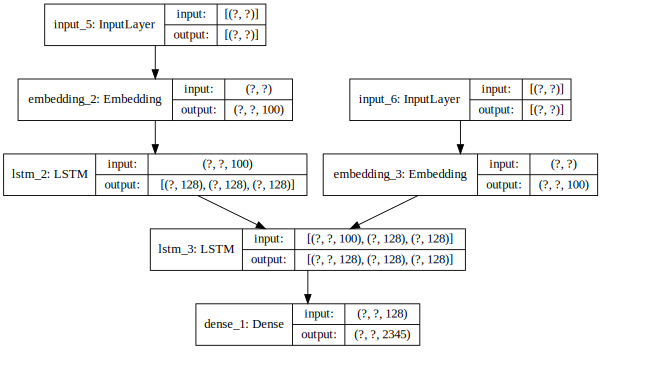

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True,dpi=65).create(prog='dot', format='svg'))

In [ ]:
input_seq = make_predict_input('프로젝트 어떻게 만들어')
sentence = generate_text(input_seq)
sentence

[[1488  351 1871    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
[array([[-5.6234356e-02, -5.9602765e-04,  8.1621009e-01,  2.8022449e-02,
        -1.4178175e-01, -5.4876893e-03, -7.8820837e-01,  1.1130145e-01,
         4.7134781e-01,  4.3815938e-03, -8.3250701e-01,  5.0032618e-03,
         4.6104219e-02, -1.9796064e-01, -8.5927838e-01, -5.8113647e-01,
         2.9364214e-03, -5.0783426e-01,  9.3334788e-01,  9.8166758e-01,
         6.2489563e-01,  7.0904076e-01,  1.7078640e-01, -7.6150107e-01,
         9.3765765e-01, -3.4927738e-01, -8.9964437e-01, -2.5008583e-01,
         9.3859535e-01,  7.7994317e-01, -7.8963381e-01,  7.3175324e-05,
         6.0023209e-03, -9.6665186e-01,  1.4993201e-04, -9.4236463e-04,
         7.3017651e-01,  7.7184522e-01, -9.8836070e-01, -7.3931193e-01,
        -1.3923394e-03,  3.2803337e-03, -7.9791367e-01,  1.3245438e-02,
        -3.7444546e-03,  9.5475996e-05, -3.003249

'프로젝트 를 생 성하겠습니다 '

In [ ]:
print(len(words))

2345


In [ ]:
print(encoder_model)